In [1]:
"""SANITY CHECK FOR:
1) LID estimation: check whether the high LID images actually look more complex
2) reconstruction loss: check the organization of batches.
"""

'SANITY CHECK FOR:\n1) LID estimation: check whether the high LID images actually look more complex\n2) reconstruction loss: check the organization of batches.\n'

In [ ]:
import json
import numpy as np
import os
# add the parent directory to the Python path
import sys
sys.path.append(os.path.abspath(".."))   # one level up from notebook/
import matplotlib.pyplot as plt
import torch
from data.utils.dataloaders import get_imagenet_dataloader


['/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python311.zip', '/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11', '/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/lib-dynload', '', '/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/site-packages', '/BS/data_mani_compress/work/thesis/thesis/external/guided-diffusion', '/BS/data_mani_compress/work/thesis/thesis/external/DenseFlow', '/BS/data_mani_compress/work/thesis/thesis']


In [30]:
# save json file
with open('/BS/data_mani_compress/work/thesis/thesis/data/datasets/imageNet_LID_values/val/t_15/lid_0000_3125.json', 'r') as f:
    lids = json.load(f)
print(len(lids))

50000


In [23]:
def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406], device=img_tensor.device).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=img_tensor.device).view(3, 1, 1)
    return img_tensor * std + mean

In [ ]:
imagenet = get_imagenet_dataloader(split="train", batch_size=4)

In [ ]:
imagenet_val = get_imagenet_dataloader(split="val_categorized", batch_size=4)

In [32]:
# find the indices of lowest and highest LID values
lids_np = np.asarray(lids, dtype=np.float64)
# argsort returns indices that would sort the array ascending
order = np.argsort(lids_np)
lowest_indices = order[:50].tolist()
highest_indices = order[-50:][::-1].tolist()  # top 20 in descending order
lowest_values = lids_np[lowest_indices].tolist()
highest_values = lids_np[highest_indices].tolist()

# also get the mid LID values for comparison
mid_start = len(lids_np) // 2 - 25
mid_indices = order[mid_start:mid_start + 50].tolist()
mid_values = lids_np[mid_indices].tolist()

In [33]:
print('Lowest 10 indices/values:')
for idx, val in zip(lowest_indices, lowest_values):
    print(idx, val)
print('\nHighest 10 indices/values:')
for idx, val in zip(highest_indices, highest_values):
    print(idx, val)

Lowest 10 indices/values:
24381 -7198047.0
36861 -7174709.5
30765 -7170869.0
40666 -7161947.5
34038 -7150667.5
20289 -7129925.5
40907 -7122817.5
28949 -7115863.0
43078 -7109677.0
34010 -7096202.0
35954 -7079538.0
5579 -7072379.0
123 -7070011.5
261 -7054183.0
22348 -7053556.5
5586 -7053416.5
21128 -7050608.5
38062 -7043270.0
40518 -7037701.5
34000 -7028971.5
22335 -7022785.0
29505 -7017345.5
247 -7010859.0
45184 -7008407.5
27866 -7006815.5
36671 -7006112.5
41439 -7000739.0
225 -7000420.0
24935 -6994123.0
48346 -6993310.5
915 -6991368.5
5562 -6988583.0
35080 -6984827.5
5552 -6979892.5
43826 -6971610.5
15708 -6966373.0
28354 -6964865.0
35039 -6963972.5
38904 -6963595.5
18738 -6963235.0
34034 -6962504.0
22878 -6962143.0
23503 -6961331.0
20917 -6961149.0
5574 -6960207.5
42250 -6960052.5
5571 -6959135.5
22039 -6952380.0
20273 -6951848.0
21896 -6950903.5

Highest 10 indices/values:
3143 -2089946.375
4584 -2376336.75
4085 -2574761.0
49513 -2604137.25
4204 -2609027.25
13908 -2658537.25
19529 -2

Saved lid_grid.pdf and lid_grid.png


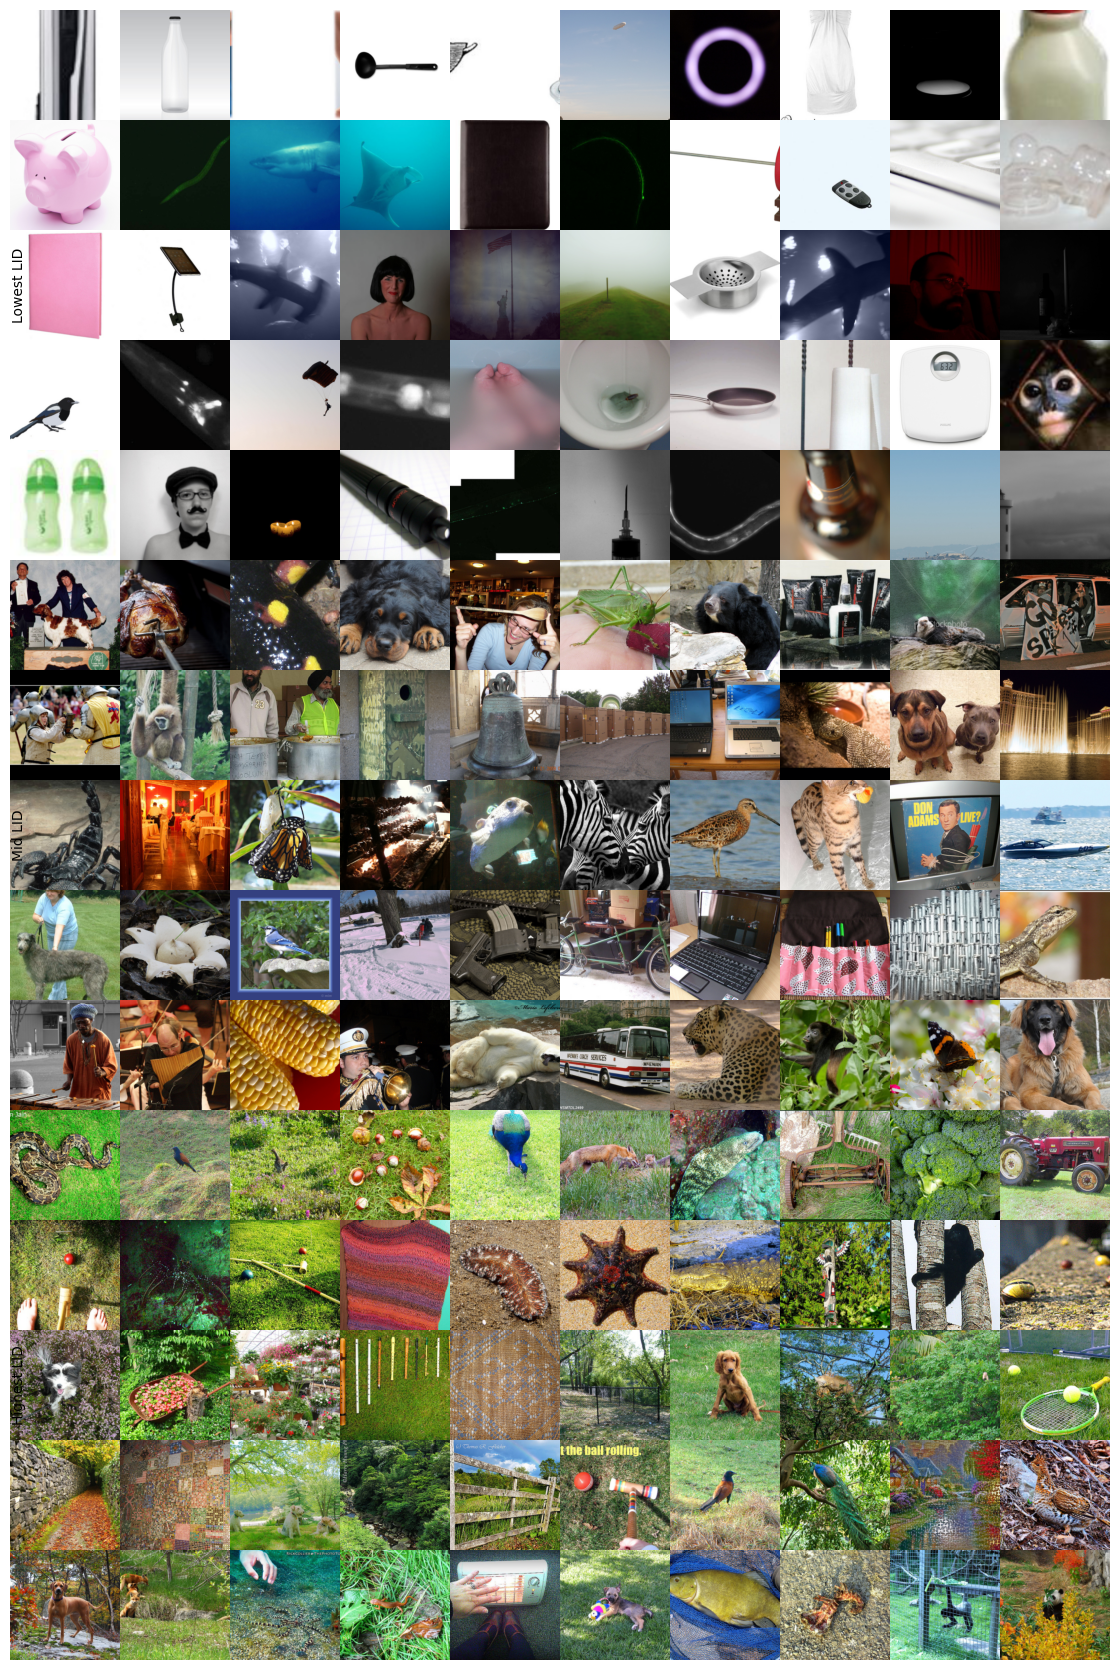

In [34]:
# Compact visualization: remove whitespace and save as PDF
import matplotlib.pyplot as plt
from pathlib import Path

# Parameters
n = 50              # images per group
rows, cols = 5, 10  # grid per group
assert rows * cols >= n, "rows*cols must cover n"

# Prepare groups
groups = [
    ("Lowest LID", lowest_indices[:n]),
    ("Mid LID",    mid_indices[:n]),
    ("Highest LID", highest_indices[:n]),
]

H = rows * len(groups)
W = cols
fig_h = 1.1 * H   # figure size scales roughly with tile count
fig_w = 1.1 * W
fig, axs = plt.subplots(H, W, figsize=(fig_w, fig_h))

# Ensure axs is 2D
if H == 1:
    axs = axs[None, :]

# Draw tiles
for gi, (gname, indices) in enumerate(groups):
    for i, idx in enumerate(indices):
        r_local, c = divmod(i, cols)
        r = gi * rows + r_local
        ax = axs[r, c]
        img = imagenet_val.dataset[idx][0]
        img = denormalize(img).clamp(0, 1).permute(1, 2, 0).cpu()
        ax.imshow(img)
        ax.set_axis_off()

# Remove all spacing and margins
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)

# Minimal group labels on the left margin without changing layout
for gi, (gname, _) in enumerate(groups):
    y = 1 - (gi + 0.5) / len(groups)
    fig.text(0.002, y, gname, va='center', ha='left', fontsize=10, color='black', rotation=90)

# Save outputs with no padding
out_pdf = Path("lid_grid.pdf")
out_png = Path("lid_grid.png")
fig.savefig(out_pdf, bbox_inches='tight', pad_inches=0, dpi=300)
fig.savefig(out_png, bbox_inches='tight', pad_inches=0, dpi=300)
print(f"Saved {out_pdf} and {out_png}")

plt.show()


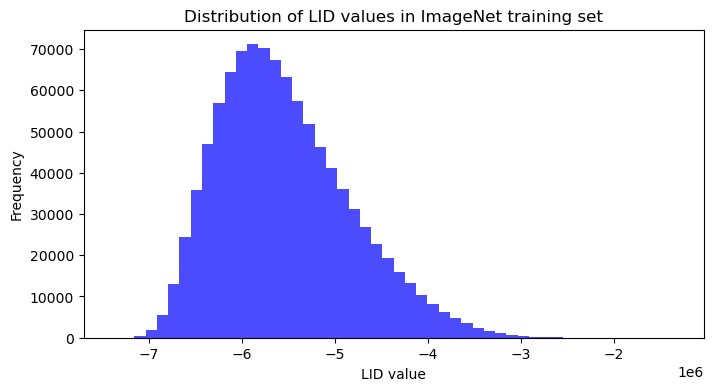

In [4]:
# plot the distribution of LID values
plt.figure(figsize=(8, 4))
plt.hist(all_lids, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of LID values in ImageNet training set')
plt.xlabel('LID value')
plt.ylabel('Frequency')
plt.show()

In [5]:
# since the LID values can be large and may be negative,
# apply a signed log transform first, then compute mean and std.
# Use NumPy arrays (not Python lists) for vectorized math.
lids_np = np.asarray(all_lids, dtype=np.float64)
mean_lid_before_log = float(lids_np.mean())  # ddof=0 (matches np.std default)
std_lid_before_log = float(lids_np.std())
print(f"Mean LID (signed log1p): {mean_lid_before_log:.4f}, Std LID (signed log1p): {std_lid_before_log:.4f}")

lids_log = np.sign(lids_np) * np.log1p(np.abs(lids_np))
mean_lid_after_log = float(lids_log.mean())  # ddof=0 (matches np.std default)
std_lid_after_log = float(lids_log.std())
print(f"Mean LID (signed log1p): {mean_lid_after_log:.4f}, Std LID (signed log1p): {std_lid_after_log:.4f}")

Mean LID (signed log1p): -5541565.5392, Std LID (signed log1p): 708356.6451
Mean LID (signed log1p): -15.5189, Std LID (signed log1p): 0.1364


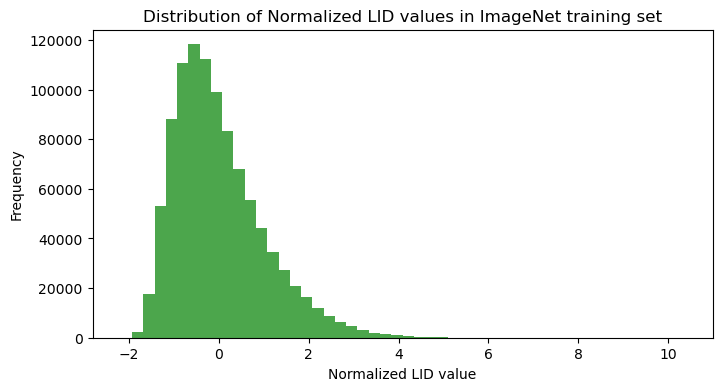

In [7]:
# plot the normalized LID values
lids_normalized_log = (lids_log - mean_lid_after_log) / std_lid_after_log
plt.figure(figsize=(8, 4))
plt.hist(lids_normalized_log, bins=50, color='green', alpha=0.7)
plt.title('Distribution of Normalized LID values in ImageNet training set')
plt.xlabel('Normalized LID value')
plt.ylabel('Frequency')
plt.show()

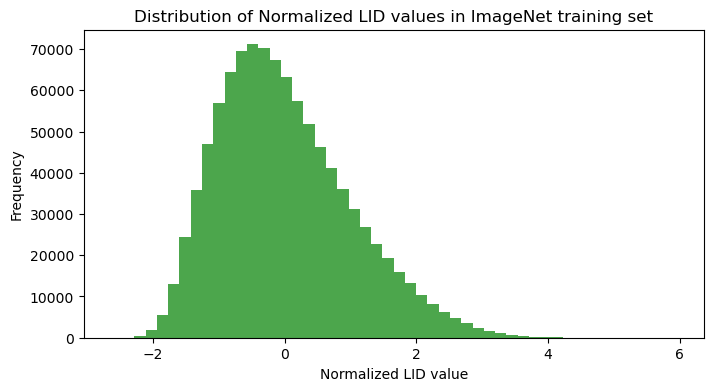

In [8]:
# plot the normalized LID values
lids_normalized = (lids_np - mean_lid_before_log) / std_lid_before_log
plt.figure(figsize=(8, 4))
plt.hist(lids_normalized, bins=50, color='green', alpha=0.7)
plt.title('Distribution of Normalized LID values in ImageNet training set')
plt.xlabel('Normalized LID value')
plt.ylabel('Frequency')
plt.show()